<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Network communities </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>March 4, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. Network data
<hr style="height:1px;border:none" />

We will examine these network data for today's exercises. They are available in the **`DataModules`** directory.
* Zachary's karate club network (`karate.gml`)
* College football network (`football.gml`)
* Brain networks (resting-state fMRI), formed from the same fMRI data from the same subject:
   * Oxford (sub16112)
     * ROI (90 nodes): `Oxford_sub16112_aal90_d5_connected_annotated.adjlist`
     * Voxel (19000 nodes): `Oxford_sub16112_voxel_d20_connected.adjlist`
   * Leiden (sub52922)
     * ROI (90 nodes): `Leiden_sub52922_aal90_d5_connected_annotated.adjlist`
     * Voxel (19000 nodes): `Leiden_sub52922_voxel_d20_connectec.adjlist`
  

# 2. What are network communities?
<hr style="height:1px;border:none" />

In some network data, you may observe that some nodes are strongly interconnected among themselves, forming clusters. On the other hand, connections between such clusters are very sparse. Such interconnected clusters of nodes are often referred as clusters, ***communities***, or ***modules***. Here is a toy example of such clusters. 

`<ToyCommunityExamples.py>`

In [1]:
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


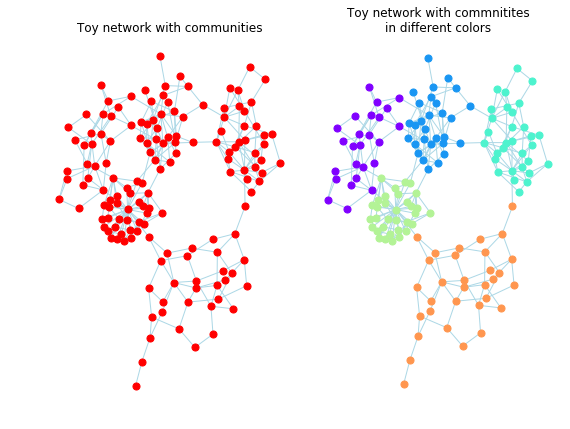

In [12]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import LFR_benchmark_graph

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


# first, a simple toy example of modular network
n = 150
tau1 = 3.0
tau2 = 2.0
mu = 0.0675
G_list = []
G = LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5,
                        min_community=25, seed=10)



# drawing the graph --- Kamada-Kawai layout
# without community assignment
plt.figure(figsize=[8,6])

plt.subplot(121)
pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
plt.title('Toy network with communities')
plt.axis('off')

# extracting community assignment indices
commIndSet = {frozenset(G.nodes[v]['community']) for v in G}
commInd = [list(x) for x in iter(commIndSet)]
nComm = len(commInd)

# drawing with community assignment
plt.subplot(122)
node_color_list = get_cmap(nComm+1,'rainbow')
nx.draw_networkx_edges(G, pos, edge_color='lightblue')
for iComm in range(nComm):
    nx.draw_networkx_nodes(G, pos, nodelist=commInd[iComm],
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=50)
plt.title('Toy network with commnitites\nin different colors')
plt.axis('off')

plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

In this particular example, only 6.75% of edges are connecting communities, while the remaining 93.25% of edges are for within-community connections. Since inter-community connections are so sparse, communities are readily identifiable just by looking at the network. However, as the fraction of inter-community connections increases, communities becomes less obvious. 

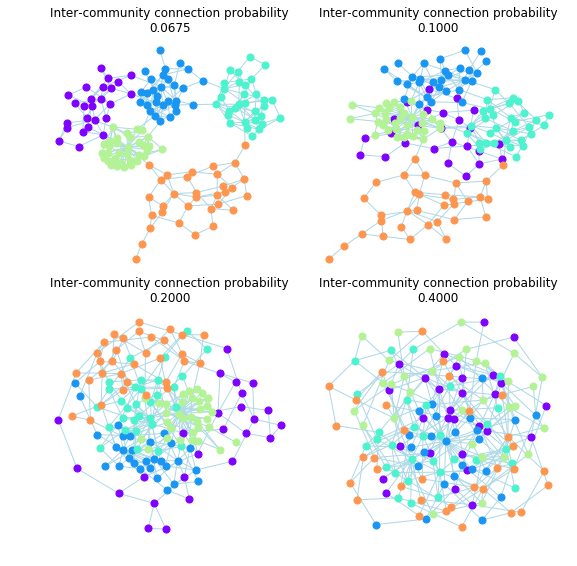

In [13]:
# generating toy networks with different inter-community connection prob
n = 150
tau1 = 3.0
tau2 = 2.0
mu = [0.0675, 0.10, 0.20, 0.40]
G_list = []
for imu in mu:
    G = LFR_benchmark_graph(n, tau1, tau2, imu, average_degree=5,
                            min_community=25, seed=10)
    G_list.append(G)

    
    

# drawing the graph --- Kamada-Kawai layout
plt.figure(figsize=[8,8])
for i,imu in enumerate(mu):
    plt.subplot(2,2,i+1)
    G = G_list[i]
    commIndSet = {frozenset(G.nodes[v]['community']) for v in G}
    commInd = [list(x) for x in iter(commIndSet)]
    nComm = len(commInd)
    node_color_list = get_cmap(nComm+1,'rainbow')

    pos = nx.kamada_kawai_layout(G, weight=None) # positions for all nodes
    for iComm in range(nComm):
        nx.draw_networkx_nodes(G, pos, nodelist=commInd[iComm],
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='lightblue')
    plt.title('Inter-community connection probability\n%6.4f' % imu)
    plt.axis('off')

plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.9,
                    left=0.05, right=0.95)
plt.show()

## Why should we care about network communities?

Because identifying network communities often reveal the underlying partition or grouping of nodes solely based on network connections. Here are two examples of that.

The first example shows the network modules in the karate club network, estimated by two methods (Girvan-Newman method and Louvain method). The Girvan-Newman method is available as the **`girvan_newman`** function in **`networkx.algorithms.community`**. Unfortunately this function returns a series of modular partitions with different numbers of communities (between 1 and n (number of nodes)). Thus I wrote a small function to find the optimal modular partition with the right number of modules (as determined by **modularity**, discussed later). The Louvain method is implemented as the **`best_partition`** function in the **`community`** library (a.k.a., **`python-louvain`**). 

The example network represents a karate club at a university, split into two groups due to an internal dispute. This data set is a well-studied network in social science. 

`<CommunityExamples.py>`

In [14]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman, modularity
import community   # Louvain method

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm, end='')
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if verbose:
            print('  Modularity : %6.4f' % Q)
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition



##### loading network data
# Karate network
G_karate = nx.read_gml('DataModules/karate.gml', label='id')  
# Football network
G_football = nx.read_gml('DataModules/football.gml')  


##### Community detection 
# Community detection with the girvan-newman algorithm
commInd_karate = girvan_newman_opt(G_karate)
commInd_football = girvan_newman_opt(G_football)
# converting the partitions into dictionaries
partition_karate_GN = {}
for i,iComm in enumerate(commInd_karate):
    for iNode in iComm:
        partition_karate_GN[iNode] = i
partition_football_GN = {}
for i,iComm in enumerate(commInd_football):
    for iNode in iComm:
        partition_football_GN[iNode] = i


# Community detection with the Louvain method
partition_karate_L = community.best_partition(G_karate)
partition_football_L = community.best_partition(G_football)

Let's visualize this network, with modules in different colors.

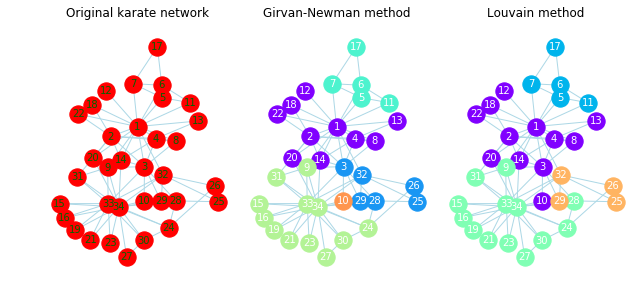

In [15]:
###### drawing the graph (karate network)
plt.figure(figsize=[9,4])

# first, graph without community assignments
plt.subplot(131)
pos = nx.kamada_kawai_layout(G_karate, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G_karate, pos)
nx.draw_networkx_edges(G_karate, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_color='DarkGreen')
plt.title('Original karate network')
plt.axis('off')
plt.xlim([-0.6, 0.65])
plt.ylim([-0.85, 1.2])

# next, graph with communities in different colors (Girvan-Newman)
plt.subplot(132)
nComm = max([comm for comm in partition_karate_GN.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_karate_GN.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_karate, pos, 
                           nodelist=nodeList,
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=300)
nx.draw_networkx_edges(G_karate, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_color='White')
plt.title('Girvan-Newman method')
plt.axis('off')
plt.xlim([-0.6, 0.65])
plt.ylim([-0.85, 1.2])

# finally, graph with communities in different colors (Louvain)
plt.subplot(133)
nComm = max([comm for comm in partition_karate_L.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_karate_L.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_karate, pos, 
                           nodelist=nodeList,
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=300)
nx.draw_networkx_edges(G_karate, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_karate, pos, font_size=10, font_color='White')
plt.title('Louvain method')
plt.axis('off')
plt.xlim([-0.6, 0.65])
plt.ylim([-0.85, 1.2])

plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

The second example is the college football network. As you can imagine, schools belonging to the same conference tend to play more often among themselves, compared to schools in different conferences. The two estimation methods produced a fairly good result predicting these conferences.

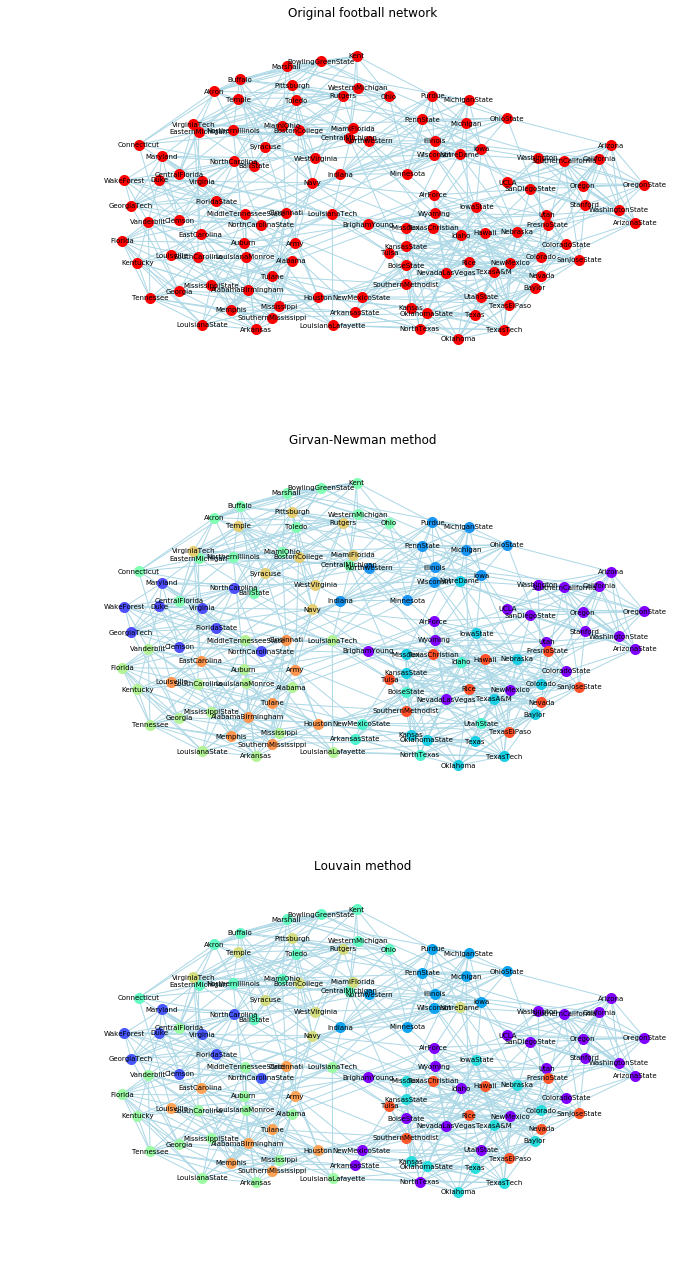

In [21]:
#### drawing the graph (football network)
plt.figure(figsize=[10,20])
plt.subplot(311)

# first, graph without community assignments
pos = nx.kamada_kawai_layout(G_football, weight=None) # positions for all nodes
nx.draw_networkx_nodes(G_football, pos, node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='Black')
plt.title('Original football network')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])

# next, graph with communities in different colors (Girvan-Newman)
plt.subplot(312)
nComm = max([comm for comm in partition_football_GN.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_football_GN.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_football, pos, 
                           nodelist=nodeList,
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='black')
plt.title('Girvan-Newman method')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])

# next, graph with communities in different colors (Louvain)
plt.subplot(313)
nComm = max([comm for comm in partition_football_L.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_football_L.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_football, pos, 
                           nodelist=nodeList,
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=100)
nx.draw_networkx_edges(G_football, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_football, pos, font_size=7, font_color='black')
plt.title('Louvain method')
plt.axis('off')
plt.xlim([-1.15, 1.15])
plt.ylim([-1.15, 1.15])


plt.subplots_adjust(hspace=0.15, wspace=0.075, bottom=0.025, top=0.875,
                    left=0.05, right=0.95)
plt.show()

# 3. Modularity
<hr style="height:1px;border:none" />

## How clustered is a network?

As I mentioned earlier, some networks consists of highly interconnected communities, while others are not. If you have community partition information, you can examine how modular a network is, using a metric called **modularity**. In a nutshell, modularity examines the fraction of within community edges and compared that to the expected fraction if connections were at random. Modularity ranges from -0.5 to 1.0. A negative modularity measure means communities are likely random, whereas a high positive modularity means the network is highly modular (i.e., communities likely exist).

The **`modularity`** function in **`networkx.algorithms.community`** calculates modularity based on the community partition information (true partition or estimated partition). There is another **`modularity`** function under **`community`** as well, which takes the partition information organized as a dictionary. 

The modularity can be calculated based on the estimated partition of a network. Community detection algorithms yielding higher modularity is often desired. Here are modularities of the karate and football networks, by the Girvan-Newman method and the Louvain method.

In [22]:
###### Modularity
print('Modularity -- karate network')
print('Girvan-Newman: %6.4f' % community.modularity(partition_karate_GN,
                                                    G_karate))
print('Louvain: %6.4f' % community.modularity(partition_karate_L,
                                              G_karate))
print()

print('Modularity -- football network')
print('Girvan-Newman: %6.4f' % community.modularity(partition_football_GN,
                                                    G_football))
print('Louvain: %6.4f' % community.modularity(partition_football_L,
                                              G_football))
print()

Modularity -- karate network
Girvan-Newman: 0.4013
Louvain: 0.4156

Modularity -- football network
Girvan-Newman: 0.5996
Louvain: 0.6042



# 4. Modular organization: brain network (ROI)
<hr style="height:1px;border:none" />

The brain network is known to be modular. We shall examine that, first with an ROI brain network (Oxford).

`<ModulesBrainROI.py>`

In [25]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman, modularity
import community   # Louvain method
import pandas as pd


##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm, end='')
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if verbose:
            print('  Modularity : %6.4f' % Q)
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition



##### loading network data
# Brain network (ROI, Oxford)
G_Oxford = nx.read_adjlist('DataModules/Oxford_sub16112_aal90_d5_connected_annotated.adjlist')  

We use both Girvan-Newman and Louvain methods to find modular organization.

In [26]:
##### Community detection 
# Community detection with the girvan-newman algorithm
commInd_Oxford = girvan_newman_opt(G_Oxford)
# converting the partitions into dictionaries
partition_Oxford_GN = {}
for i,iComm in enumerate(commInd_Oxford):
    for iNode in iComm:
        partition_Oxford_GN[iNode] = i


# Community detection with the Louvain method
partition_Oxford_L = community.best_partition(G_Oxford)

The modularity for both methods.

In [27]:
###### Modularity
print('Modularity')
print('Girvan-Newman: %6.4f' % community.modularity(partition_Oxford_GN,
                                                    G_Oxford))
print('Louvain: %6.4f' % community.modularity(partition_Oxford_L,
                                              G_Oxford))

Modularity
Girvan-Newman: 0.6238
Louvain: 0.6463


Let's examine the network. First, just the network without modular partition.

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


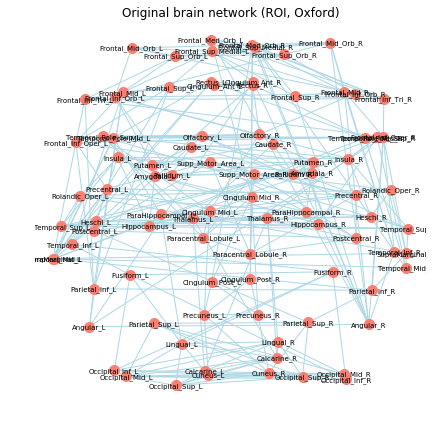

In [28]:
###### drawing the graph 
# loading the coordinates info for brain areas
AALTable = pd.read_csv('DataModules/aal_MNI_V4_coord.csv')
# dictionary of xy-coordinates
pos = {}
for i in range(1,91):
    pos[AALTable.iloc[i-1,1]] = np.array(AALTable.loc[i-1,
                                                      ['centerX',
                                                       'centerY']])

# first, graph without community assignments
plt.figure(figsize=[7,7])
nx.draw_networkx_nodes(G_Oxford, pos, node_color='salmon',
                       node_size=100)
nx.draw_networkx_edges(G_Oxford, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_Oxford, pos, font_size=7, font_color='black')
plt.title('Original brain network (ROI, Oxford)')
plt.axis('off')
plt.show()

Now, modular organization based on Girvan-Newman.

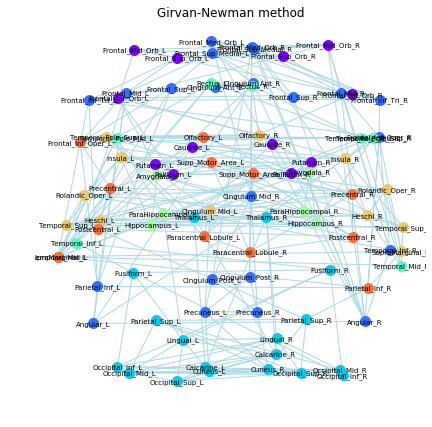

In [29]:
# next, graph with communities in different colors (Girvan-Newman)
plt.figure(figsize=[7,7])
nComm = max([comm for comm in partition_Oxford_GN.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_Oxford_GN.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_Oxford, pos, 
                           nodelist=nodeList,
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=100)
nx.draw_networkx_edges(G_Oxford, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_Oxford, pos, font_size=7, font_color='Black')
plt.title('Girvan-Newman method')
plt.axis('off')
plt.show()

Finally, modular organization based on Louvain.

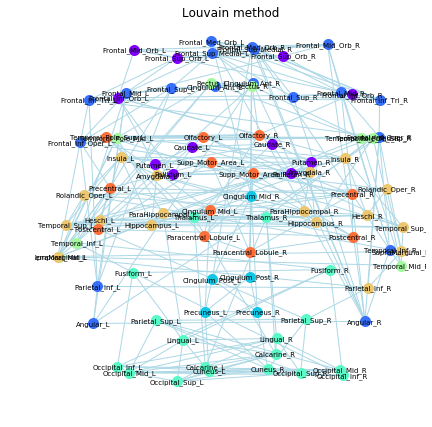

In [30]:
# finally, graph with communities in different colors (Louvain)
plt.figure(figsize=[7,7])
nComm = max([comm for comm in partition_Oxford_L.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_Oxford_L.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_Oxford, pos, 
                           nodelist=nodeList,
                           node_color = np.array([node_color_list(iComm)]),
                           node_size=100)
nx.draw_networkx_edges(G_Oxford, pos,
                       edge_color='lightblue')
nx.draw_networkx_labels(G_Oxford, pos, font_size=7, font_color='Black')
plt.title('Louvain method')
plt.axis('off')
plt.show()

### Exercise
The modular partition in both methods are stored in dictionaries (**`partition_Oxford_GN`** (Girvan-Newman) and **`partition_Oxford_L`** (Louvain)), with keys corresponding to the nodes and the accompanying values as module numbers. 
1. **Default mode network, Girvan-Newman**. One of the consistently identified brain network modules is the default mode network (DMN). The DMN typically includes the posterior cingulate cortex (`Cingulum_Post_L` and `Cingulum_Post_R`), the precuneus (`Precuneus_L` and `Precuneus_R`). Identify the DMN module in the modular partition by Girvan-Newman, by finding the module containing `Cingulum_Post_L`. Then create a list of nodes included in that module.
2. **Default mode network, Louvain**. Repeat the exercise 1 above with the partition based on the Louvain method.
3. **DMN by Louvain in Leiden network**. Identify modular partition in the Leiden ROI brain network, by the Louvain method. Then identify nodes included in the DMN module. Is there a similarity between the DMN nodes in the Oxford network?

# 5. Modular organization: brain network (voxel)
<hr style="height:1px;border:none" />

Modular organization can also be found in a brain network formed at the voxel-level. We shall examine the Oxford voxel network.

`<ModulesBrainVoxel.py>`

In [33]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community   # Louvain method
import pandas as pd

##### Parameters
voxDim = [46, 56, 42]


##### loading network data
# Brain network (Voxel, Oxford)
G = nx.read_adjlist('DataModules/Oxford_sub16112_voxel_d20_connected.adjlist',
                    nodetype=int)  

For modular partition, I am using the Louvain method only. It may take a few minutes to run the algorithm.

In [34]:
##### Community detection 
# Community detection with the Louvain method
partition_L = community.best_partition(G)

#np.save('DataModules/partition_L.npy', partition_L)
#partition_L = np.load('DataModules/partition_L.npy').item()

It is hard to visualize the network itself, so we will visualize voxels (i.e., nodes) belonging to different modules.

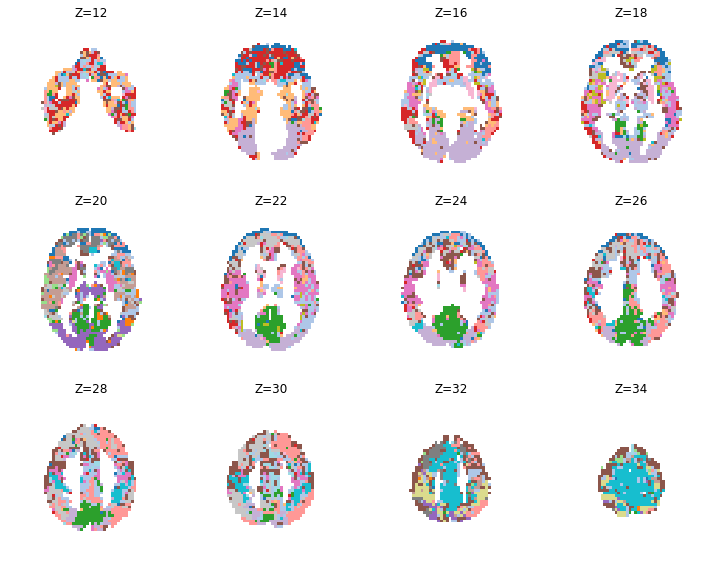

In [35]:
##### Creating a 3D image of module assignments
X = np.zeros(voxDim)  # initializing the module image
nComm = max([comm for comm in partition_L.values()])+1
for iComm in range(nComm):
    # list of nodes in a particular module
    nodeList = [iNode for iNode,Comm in partition_L.items()
                if Comm==iComm]
    # converting the node number (linear index) to 3D coord
    nodeXYZ = np.unravel_index(nodeList, voxDim)
    X[nodeXYZ] = iComm+1

# blanking the background
X[X==0] = None



##### visualing the modules in the brain space
plt.figure(figsize=[10,8])

for i,z in enumerate(np.arange(12,35,2)):
    plt.subplot(3,4,i+1)
    plt.imshow(np.rot90(X[:,:,z]), cmap='tab20')
    plt.title('Z='+str(z))
    plt.axis('off')

plt.subplots_adjust(hspace=0.2, wspace=0.0, bottom=0.025, top=0.95,
                    left=0, right=1.0)
plt.show()

Different colors correspond to different modules. As you can see, although there are some 'speckles', nodes belonging to the same modules are spatially contiguous. 

# 6. Cartography: brain network (ROI)
<hr style="height:1px;border:none" />

Now that we identified the modular organization of the brain network, we shall examine the roles of each node as described in the Guimera & Amaral paper. To do so, I have written short functions to calculate within-module degree Z scores and participation coefficients. 

`<CartographyBrainROI.py>`

In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman, modularity
import community   # Louvain method
import pandas as pd


##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


##### girman-newman method, optimized with modularity
def girvan_newman_opt(G, verbose=False):
    runningMaxMod = 0
    commIndSetFull = girvan_newman(G)
    for iNumComm in range(2,len(G)):
        if verbose:
            print('Commnity detection iteration : %d' % iNumComm, end='')
        iPartition = next(commIndSetFull)  # partition with iNumComm communities
        Q = modularity(G, iPartition)  # modularity
        if verbose:
            print('  Modularity : %6.4f' % Q)
        if Q>runningMaxMod:  # saving the optimum partition and associated info
            runningMaxMod = Q
            OptPartition = iPartition
    return OptPartition


###### Within module degree function
def withinModDegree(G, partition):
    '''
    Calculates within module degrees, then returns the 
    Z-scores as a dictionary
    '''
    # number of modules
    nComm = max([comm for comm in partition.values()])+1
    # initialize output dictionary
    dictZ = {}
    # loop over communitites
    for iComm in range(nComm):
        # list of nodes for the module
        nodeList = [iNode for iNode,Comm in partition.items()
                    if Comm==iComm] 
        GMod = G.subgraph(nodeList)  # subgraph for the module
        KMod = dict(GMod.degree())  # degree sequence for the module
        KModList = [K for K in KMod.values()]
        meanK = np.mean(KModList)  # mean degree
        sdK = np.std(KModList)     # sd degree
        # loop over nodes within the module
        for iNode in nodeList:
            dictZ[iNode] = (KMod[iNode]-meanK)/sdK
    return dictZ


###### Participation coefficient function
def PC(G, partition):
    '''
    Calculates participation coefficients, then returns the
    PCs as a dictionary
    '''
    # number of modules
    nComm = max([comm for comm in partition.values()])+1
    # degree sequence for the original network
    dictK = dict(G.degree())
    # initialize the dictionary for intermediate results
    dictSum = {}
    # for loop over communitites
    for iComm in range(nComm):
        # list of nodes for the module
        nodeList = [iNode for iNode,Comm in partition.items()
                    if Comm==iComm] 
        GMod = G.subgraph(nodeList)  # subgraph for the module
        KMod = dict(GMod.degree())  # degree sequence for the module
        # loop over nodes within the module
        for iNode in nodeList:
            dictSum.setdefault(iNode,0)
            dictSum[iNode] += (KMod[iNode]/dictK[iNode])**2
    # converting to pc
    dictPC = {}
    for iNode, iSum in dictSum.items():
        dictPC[iNode] = 1 - iSum
    # returning the PC dictionary
    return dictPC

Loading the network data.

In [38]:
##### loading network data
# Brain network (ROI, Oxford)
G = nx.read_adjlist('DataModules/Oxford_sub16112_aal90_d5_connected_annotated.adjlist')  

Finding the modular partition, by Girvan-Newman as well as Louvain.

In [39]:
##### Community detection 
# Community detection with the girvan-newman algorithm
commInd = girvan_newman_opt(G)
# converting the partitions into dictionaries
partition_GN = {}
for i,iComm in enumerate(commInd):
    for iNode in iComm:
        partition_GN[iNode] = i


# Community detection with the Louvain method
partition_L = community.best_partition(G)

Calculating Z (within-module degree) and PC (participation coefficient). These are returned as dictionaries.

In [40]:
##### degree sequence
dictK = dict(G.degree())

##### Within node degree Z-scores
dictZ_GN = withinModDegree(G, partition_GN)
dictPC_GN = PC(G, partition_GN)

For the ease of assessing the results, I am combining degree, Z, and PC, as well as the module assignments into a dataframe. I shall do this for Girvan-Newman only.

In [41]:
##### Creating a dataframe for all info
dataModules = pd.DataFrame(partition_GN.items(),
                           columns=['Node','ModuleID'])
# adding degree (from the original network)
dataModules = pd.merge(dataModules,
                       pd.DataFrame(dictK.items(),columns=['Node','Degree']),
                       on='Node')
# adding Z score
dataModules = pd.merge(dataModules,
                       pd.DataFrame(dictZ_GN.items(),columns=['Node','Z']),
                       on='Node')
# adding PC
dataModules = pd.merge(dataModules,
                       pd.DataFrame(dictPC_GN.items(),columns=['Node','PC']),
                       on='Node')

Then assigning a node role based on Z and PC for each node.

In [42]:
##### assigning roles
role = []
for i, iRow in dataModules.iterrows():
    # hubs or non-hubs
    if iRow.Z>=2.5:  # hubs
        if iRow.PC<=0.3:
            role.append(5)   # 5: provincial hub
        elif iRow.PC<=0.75:
            role.append(6)   # 6: connector hub
        else:
            role.append(7)   # 7: kinless hub
    else:
        if iRow.PC<=0.05:
            role.append(1)   # 1: ultra-peripheral node
        elif iRow.PC<=0.63:
            role.append(2)   # 2: peripheral node
        elif iRow.PC<=0.8:
            role.append(3)   # 3: non-hub connector node
        else:
            role.append(4)   # 4: non-hub kinless node
dataModules['Role'] = role

Since this is a small network, there is no hub node. However, I am making a list of high Z and PC nodes in the network.

In [44]:
###### List of (psudo-)hubs
dataModules.sort_values(by='Z', ascending=False).head(5)

,Node,ModuleID,Degree,Z,PC,Role
23,Angular_R,1,10,2.340823,0.190000,2
34,Occipital_Mid_L,2,10,2.057983,0.000000,1
56,Temporal_Pole_Mid_R,3,6,2.000000,0.000000,1
7,Frontal_Inf_Orb_L,0,8,1.732051,0.437500,2
22,Frontal_Sup_Medial_R,1,9,1.697097,0.209877,2


In [43]:
###### List of kinless nodes with high PC
dataModules.sort_values(by='PC', ascending=False).head(5)

,Node,ModuleID,Degree,Z,PC,Role
82,Parietal_Inf_R,6,5,-1.690309,0.960000,4
76,Olfactory_R,5,6,-1.555428,0.888889,4
81,Frontal_Inf_Oper_L,6,8,-0.676123,0.859375,4
70,SupraMarginal_R,5,5,-1.555428,0.840000,4
88,Olfactory_L,6,5,-1.183216,0.840000,4


I am generating the Z-PC plot for this network.

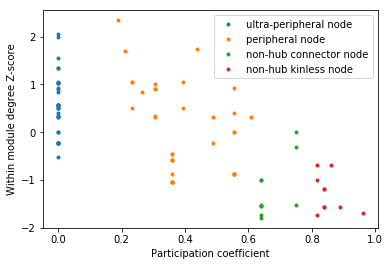

In [45]:
# Plotting PC vs Z
roleString = {1:'ultra-peripheral node',
              2:'peripheral node',
              3:'non-hub connector node',
              4:'non-hub kinless node'}
for iRole in range(1,5):
    plt.plot(dataModules[dataModules.Role==iRole].PC,
             dataModules[dataModules.Role==iRole].Z,
             '.', label=roleString[iRole])
plt.xlabel('Participation coefficient')
plt.ylabel('Within module degree Z-score')
plt.legend()
plt.show()

### Exercise
1. **High Z and PC nodes, Louvain partition**. Produce lists of high Z and PC nodes based on the Louvain partition.
2. **Z-PC plot, Louvain partition**. Produce a Z-PC plot based on the Louvain partition.

# 7. Cartography: brain network (Voxel)
<hr style="height:1px;border:none" />

Now let us assign node roles to the Louvain partition on the Oxford voxel brain network. 

`<CartographyBrainVoxel.py>`

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community   # Louvain method
import pandas as pd

##### Parameters
voxDim = [46, 56, 42]


###### Within module degree function
def withinModDegree(G, partition):
    '''
    Calculates within module degrees, then returns the 
    Z-scores as a dictionary
    '''
    # number of modules
    nComm = max([comm for comm in partition.values()])+1
    # initialize output dictionary
    dictZ = {}
    # loop over communitites
    for iComm in range(nComm):
        # list of nodes for the module
        nodeList = [iNode for iNode,Comm in partition.items()
                    if Comm==iComm] 
        GMod = G.subgraph(nodeList)  # subgraph for the module
        KMod = dict(GMod.degree())  # degree sequence for the module
        KModList = [K for K in KMod.values()]
        meanK = np.mean(KModList)  # mean degree
        sdK = np.std(KModList)     # sd degree
        # loop over nodes within the module
        for iNode in nodeList:
            dictZ[iNode] = (KMod[iNode]-meanK)/sdK
    return dictZ


###### Participation coefficient function
def PC(G, partition):
    '''
    Calculates participation coefficients, then returns the
    PCs as a dictionary
    '''
    # number of modules
    nComm = max([comm for comm in partition.values()])+1
    # degree sequence for the original network
    dictK = dict(G.degree())
    # initialize the dictionary for intermediate results
    dictSum = {}
    # for loop over communitites
    for iComm in range(nComm):
        # list of nodes for the module
        nodeList = [iNode for iNode,Comm in partition.items()
                    if Comm==iComm] 
        GMod = G.subgraph(nodeList)  # subgraph for the module
        KMod = dict(GMod.degree())  # degree sequence for the module
        # loop over nodes within the module
        for iNode in nodeList:
            dictSum.setdefault(iNode,0)
            dictSum[iNode] += (KMod[iNode]/dictK[iNode])**2
    # converting to pc
    dictPC = {}
    for iNode, iSum in dictSum.items():
        dictPC[iNode] = 1 - iSum
    # returning the PC dictionary
    return dictPC


##### loading network data
# Brain network (Voxel, Oxford)
G = nx.read_adjlist('DataModules/Oxford_sub16112_voxel_d20_connected.adjlist',
                    nodetype=int)  

We are using the module partition information saved as a file, rather than running the Louvain method again.

In [4]:
##### Community detection 
# Community detection with the Louvain method
#partition_L = community.best_partition(G)

#np.save('DataModules/partition_L.npy', partition_L)
partition_L = np.load('DataModules/partition_L.npy').item()

Then we create a dataframe of Z, PC, degree, and node roles.

In [5]:
##### degree sequence
dictK = dict(G.degree())

##### Within node degree Z-scores
dictZ_L = withinModDegree(G, partition_L)
dictPC_L = PC(G, partition_L)


##### Creating a dataframe for all info
dataModules = pd.DataFrame(partition_L.items(),
                           columns=['Node','ModuleID'])
# adding degree (from the original network)
dataModules = pd.merge(dataModules,
                       pd.DataFrame(dictK.items(),columns=['Node','Degree']),
                       on='Node')
# adding Z score
dataModules = pd.merge(dataModules,
                       pd.DataFrame(dictZ_L.items(),columns=['Node','Z']),
                       on='Node')
# adding PC
dataModules = pd.merge(dataModules,
                       pd.DataFrame(dictPC_L.items(),columns=['Node','PC']),
                       on='Node')

##### assigning roles
role = []
for i, iRow in dataModules.iterrows():
    # hubs or non-hubs
    if iRow.Z>=2.5:  # hubs
        if iRow.PC<=0.3:
            role.append(5)   # 5: provincial hub
        elif iRow.PC<=0.75:
            role.append(6)   # 6: connector hub
        else:
            role.append(7)   # 7: kinless hub
    else:
        if iRow.PC<=0.05:
            role.append(1)   # 1: ultra-peripheral node
        elif iRow.PC<=0.63:
            role.append(2)   # 2: peripheral node
        elif iRow.PC<=0.8:
            role.append(3)   # 3: non-hub connector node
        else:
            role.append(4)   # 4: non-hub kinless node
dataModules['Role'] = role

Finally generating the Z-PC plot.

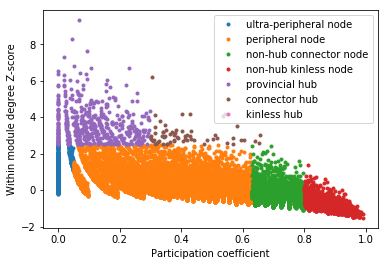

In [6]:
# Plotting PC vs Z
roleString = {1:'ultra-peripheral node',
              2:'peripheral node',
              3:'non-hub connector node',
              4:'non-hub kinless node',
              5:'provincial hub',
              6:'connector hub',
              7:'kinless hub'}
for iRole in range(1,8):
    plt.plot(dataModules[dataModules.Role==iRole].PC,
             dataModules[dataModules.Role==iRole].Z,
             '.', label=roleString[iRole])
plt.xlabel('Participation coefficient')
plt.ylabel('Within module degree Z-score')
plt.legend()
plt.show()

It seems that the majority of hub nodes are provincial hubs, with a small number of connector hubs. It appears that there is no kinless hub. We can examine the location of provincial and connector hubs in the brain space (provincial hubs: orange, connector hubs: red).

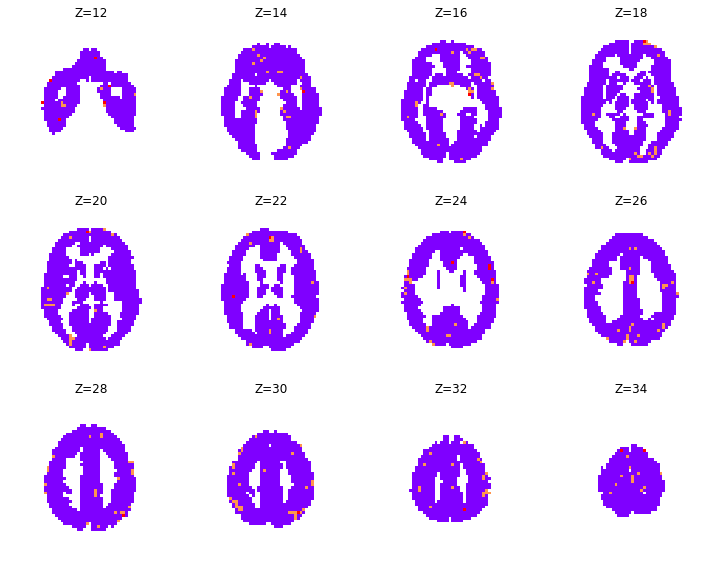

In [8]:
##### Creating a 3D image of brain voxels
X = np.zeros(voxDim)
voxelList = list(dataModules.Node)
# converting the node number (linear index) to 3D coord
voxelXYZ = np.unravel_index(voxelList, voxDim)
X[voxelXYZ] = 1 

# blanking the background
X[X==0] = None


##### adding hubs in the image
## provincial hubs (R5)
hubList = list(dataModules[dataModules.Role==5].Node)
# converting the node number (linear index) to 3D coord
hubXYZ = np.unravel_index(hubList, voxDim)
X[hubXYZ] = 5

## connector hubs (R6)
hubList = list(dataModules[dataModules.Role==6].Node)
# converting the node number (linear index) to 3D coord
hubXYZ = np.unravel_index(hubList, voxDim)
X[hubXYZ] = 6





##### visualing the Hubs in the brain space
plt.figure(figsize=[10,8])

for i,z in enumerate(np.arange(12,35,2)):
    plt.subplot(3,4,i+1)
    plt.imshow(np.rot90(X[:,:,z]), cmap='rainbow')
    plt.title('Z='+str(z))
    plt.axis('off')

plt.subplots_adjust(hspace=0.2, wspace=0.0, bottom=0.025, top=0.95,
                    left=0, right=1.0)
plt.show()

Hubs seem to be evenly distributed throughout the brain, as opposed to concentrated in certain areas of the brain. 

# *Further readings*
<hr style="height:1px;border:none" />

* Bertolero MA et al. 2015. The modular and integrative functional architecture of the human brain. PNAS 112:E6798-E6807
* Joyce KE et al. 2010. A new measure of centrality for brain networks. PloS one, 5:e12200